In [ ]:
import os
import math
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from PIL import Image
import zipfile
import urllib.request
import os.path
from IPython.display import display

import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#4/rQHis9i6K34XFynk3YJcBeGtsficMpxWds--DqmDSd8pK-6ToIx8mIk
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
root_path = 'gdrive/My Drive/CheXnet/'  #change dir to your project folder

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ykycheng","key":"f33b562afa7b468bc1261b05f0452608"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
!kaggle datasets download nih-chest-xrays/sample -p /content/CheXnet

100% 4.18G/4.20G [00:47<00:00, 163MB/s]
100% 4.20G/4.20G [00:48<00:00, 93.6MB/s]


In [ ]:
with zipfile.ZipFile('/content/CheXnet/sample.zip', 'r') as z:
    for f in z.filelist:
        print(f.filename)
        break

sample/images/00000013_005.png


In [ ]:
class DataPreprocessing(Dataset):

    classEncoding = {
        'Atelectasis': torch.FloatTensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Consolidation': torch.FloatTensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Infiltration': torch.FloatTensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Pneumothorax': torch.FloatTensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Edema': torch.FloatTensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Emphysema': torch.FloatTensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Fibrosis': torch.FloatTensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
        'Effusion': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
        'Pneumonia': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
        'Pleural_Thickening': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
        'Cardiomegaly': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
        'Nodule': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
        'Hernia': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
        'Mass': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
        'No Finding': torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    }

    def __init__(self,classEncoding=classEncoding, max_samples=None):
        self.image_names = []
        self.labels = []
        with zipfile.ZipFile('/content/CheXnet/sample.zip', 'r') as z:
          f = z.open('sample_labels.csv','r')
          title = True
          for line in f:
            if (title):
              title = False
              continue
            items = str(line).split(",")
            image_name = items[0][2:]
            image_name = os.path.join("sample/images/", image_name)
            self.image_names.append(image_name)

            label = items[1]  # list of diseases
            diseases_list = label.split("|")
            labelTensor = torch.FloatTensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
            for disease in diseases_list:
              labelTensor = labelTensor.add(classEncoding[disease])
            self.labels.append(labelTensor)

            if max_samples and len(self.image_names) >= max_samples:
              break



    def __getitem__(self, index):
      image_path = self.image_names[index]
      with zipfile.ZipFile('/content/CheXnet/sample.zip', 'r') as z:
        image = Image.open(z.open(image_path,'r')).convert('RGB')
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        preprocess = transforms.Compose([
            transforms.Resize(256),
            #transforms.TenCrop(224),
            #transforms.Lambda
            #(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            #transforms.Lambda
            #(lambda crops: torch.stack([normalize(crop) for crop in crops]))
            #transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        image = preprocess(image)
      return image, self.labels[index]


    def __len__(self):
        return len(self.image_names)



In [ ]:
def compute_score_with_logits(logits, labels):
  logits = torch.max(logits, 1)[1].data # argmax
  one_hots = torch.zeros(*labels.size()).cuda()
  one_hots.scatter_(1, logits.view(-1, 1), 1)
  scores = (one_hots * labels)

  return scores

def tile(a, dim, n_tile):
  init_dim = a.size(dim)
  repeat_idx = [1] * a.dim()
  repeat_idx[dim] = n_tile
  a = a.repeat(*(repeat_idx))
  order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)]))
  return torch.index_select(a, dim, order_index)

def get_label_for_image(model, image_path):
  classes = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis',
      'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Hernia', 'Mass', 'No Finding']
  input_image_grey = Image.open(image_path)
  input_image = input_image_grey.convert('RGB')
  preprocess = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                   ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)
  output = model(input_batch)
  index_tensor = torch.argmax(output)
  index = index_tensor.item()
  return classes[index]

In [ ]:
class DenseNet121(nn.Module):
    def __init__(self):
        super(DenseNet121, self).__init__()

        self.densenet121 = torchvision.models.densenet121(pretrained=True)

        self.model = torchvision.models.densenet121(pretrained=True)
        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 15),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

Train with DesNet

In [ ]:
# use num images
num = 2000

data = DataPreprocessing(max_samples=num)
train_set, test_set = random_split(data, [math.ceil(len(data) * 0.8), math.floor(len(data) * 0.2)])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

classes = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis',
      'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Hernia', 'Mass', 'No Finding']

model = DenseNet121().cuda()
model = nn.DataParallel(model).cuda()
# print(model)
# train = Train(train_set, model.cuda())

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
%%time

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):  # loop over the dataset multiple times

    running_loss = 0.0
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader, 0):
        # images.shape -> [batch_size, 3, 224, 224]
        # labels.shape -> [batch_size, 15]

        images = images.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        correct += compute_score_with_logits(outputs, labels).sum()
        total += labels.size(0)

    print('Epoch: %d, loss: %.3f, Accuracy: %.3f' %
          (epoch + 1, running_loss / len(trainloader), 100 * correct / total))

print('Finished Training')

Epoch: 1, loss: 0.232, Accuracy: 55.688
Epoch: 2, loss: 0.200, Accuracy: 57.250
Epoch: 3, loss: 0.192, Accuracy: 57.562
Finished Training
CPU times: user 1min 42s, sys: 2.63 s, total: 1min 45s
Wall time: 10min 12s


In [ ]:
model.eval()

DataParallel(
  (module): DenseNet121(
    (densenet121): DenseNet(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _Dens

In [ ]:
# Function to convert tensor to image
def tensor_to_image(tensor):
    tensor = tensor.cpu()  # Move to CPU
    tensor = tensor.squeeze(0)  # Remove batch dimension
    img = tensor.numpy().transpose(1, 2, 0)  # Rearrange dimensions
    img = img.clip(0, 1)  # Normalize if needed
    return img

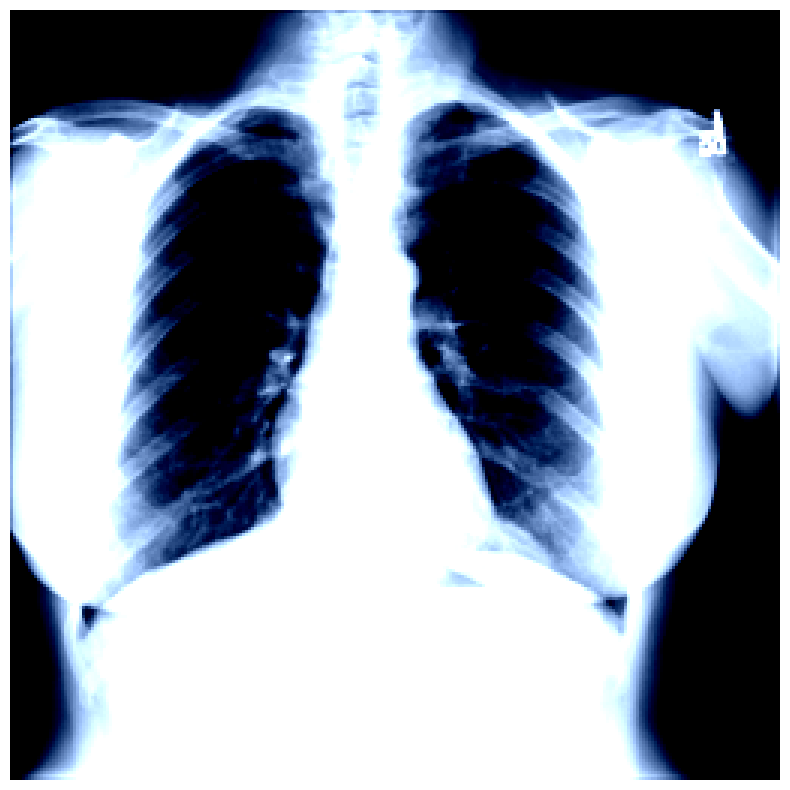

Accuracy on test set: 59.000
CPU times: user 53.2 s, sys: 403 ms, total: 53.6 s
Wall time: 53.7 s


In [ ]:
%%time

correct = 0
total = 0
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader, 0):

        images = images.cuda()
        labels = labels.cuda()

        outputs = model(images)
        correct += compute_score_with_logits(outputs, labels).sum()
        total += labels.size(0)

        if i < 1:
            plt.figure(figsize=(10, 10))
            plt.imshow(tensor_to_image(images[0]))
            plt.axis('off')
            plt.show()

print('Accuracy on test set: %.3f' % (100 * correct / total))

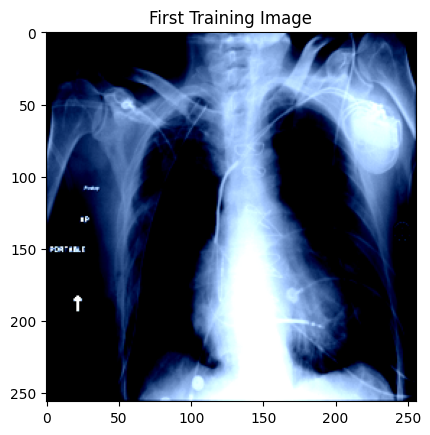

Label for the first image: ['Emphysema', 'Cardiomegaly']


In [ ]:
dataset = data

image, label = dataset[1]

# tensor -> image
image_to_show = image.permute(1, 2, 0)  # CxHxW to HxWxC
image_to_show = image_to_show.numpy()

plt.imshow(image_to_show)
plt.title("First Training Image")
plt.show()

# label number to number
diseases = []
for i, disease in enumerate(DataPreprocessing.classEncoding.keys()):
    if label[i] == 1:
        diseases.append(disease)

print("Label for the first image:", diseases)


In [ ]:
# improve PCA time

In [ ]:
%%time
# 1. data preprocessing for PCA

all_images = [] # Store processed images
dataset = data
# traverse dataset to get and transform images
length = len(dataset)
for i in range(length):
    image, label = dataset[i]  # get ith sample
    #image = image.view(10, -1)  # reshpae to 1D vector
    image = image.view(1, -1)
    all_images.append(image)

# cat all images into one big data matrix
all_images_matrix = torch.cat(all_images, dim=0).numpy()

CPU times: user 4min 3s, sys: 2.43 s, total: 4min 6s
Wall time: 4min 8s


In [ ]:
%%time
# Build PCA model
n_components = 500

pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(all_images_matrix)

# shape after PCA
print(pca_result.shape)  #(number of images, n_components)

(2000, 500)
CPU times: user 1min 50s, sys: 11.5 s, total: 2min 2s
Wall time: 1min 25s


In [ ]:
%%time

class PCADataset(Dataset):
    def __init__(self, pca_data, original_dataset):
        self.labels = [label for _, label in original_dataset]
        self.images = pca_data

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return torch.tensor(self.images[index], dtype=torch.float), self.labels[index]

pca_dataset = PCADataset(pca_result, data)

CPU times: user 4min 10s, sys: 1.47 s, total: 4min 11s
Wall time: 4min 13s


In [ ]:
pca_dataset

In [ ]:
pca_dataset
print(len(pca_dataset))
image, label = pca_dataset[0] # get first sample
print(image.shape, label.shape)

2000
torch.Size([500]) torch.Size([15])


In [ ]:
train_set, test_set = random_split(pca_dataset, [math.ceil(len(data) * 0.8), math.floor(len(data) * 0.2)])

trainloader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)

classes = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis',
      'Effusion', 'Pneumonia', 'Pleural_Thickening', 'Cardiomegaly', 'Nodule', 'Hernia', 'Mass', 'No Finding']

In [ ]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FullyConnectedNN, self).__init__()
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # second layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        # third layer
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = 500  # number of features
hidden_size = 150
num_classes = 15

model = FullyConnectedNN(input_size, hidden_size, num_classes)
model = model.cuda()

In [ ]:
%%time

criterion = nn.BCEWithLogitsLoss()  # or use nn.CrossEntropyLoss() ?
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(3):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, (features, labels) in enumerate(trainloader, 0):
        features = features.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(features)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += compute_score_with_logits(outputs, labels).sum()
        total += labels.size(0)

    print('Epoch: %d, loss: %.3f, Accuracy: %.3f' %
          (epoch + 1, running_loss / len(trainloader), 100 * correct / total))

print('Finished Training')

Epoch: 1, loss: 0.241, Accuracy: 54.500
Epoch: 2, loss: 0.195, Accuracy: 58.688
Epoch: 3, loss: 0.183, Accuracy: 60.125
Finished Training
CPU times: user 2.52 s, sys: 1.31 s, total: 3.84 s
Wall time: 5.14 s


In [ ]:
%%time

correct = 0
total = 0
with torch.no_grad():
    for i, (features, labels) in enumerate(testloader, 0):
        features = features.cuda()
        labels = labels.cuda()

        outputs = model(features)
        correct += compute_score_with_logits(outputs, labels).sum()
        total += labels.size(0)

print('Accuracy on test set: %.3f' % (100 * correct / total))

Accuracy on test set: 54.250
CPU times: user 55.2 ms, sys: 964 µs, total: 56.2 ms
Wall time: 56.9 ms
